# Intro to SITH (Scale-Invariant Temporal History)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/compmem/sithshow/blob/main/examples/cme_demo.ipynb)


In [ ]:
!pip install -q SITHshow@git+https://github.com/compmem/SITHshow

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sithshow import CMECell

SITH stores a fuzzy history in each of its temporal receptive fields by default. To see this, let's work through an example. Here's a simple 1D signal.

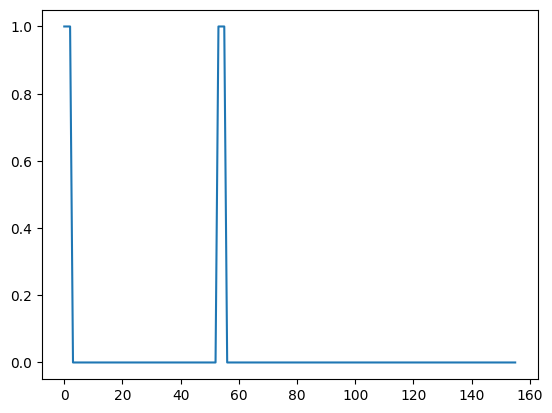

In [2]:
signal = jnp.concatenate([jnp.ones(3), jnp.zeros(50), jnp.ones(3), jnp.zeros(100)])
plt.plot(signal);

What happens when we pass the signal through SITH? 

In [20]:
sith_cell = CMECell(in_size='scalar',
                    tau_min=1, 
                    tau_max=500,
                    n_taus=20,
                    max_fn_evals=10,
                    g=0)

def track_signal_over_time(signal):    
    def step(F, f):
        F, til_f = sith_cell(F, f, alpha=jnp.ones_like(f))
            
        return F, til_f

    final_F, til_fs = jax.lax.scan(step, sith_cell.get_init_F(delta=False), signal)

    return til_fs

sith_output = track_signal_over_time(signal)

print(f'{sith_output.shape}: (sequence length x n temporal receptive fields)')

(156, 20): (sequence length x n temporal receptive fields)


We'll plot a subset of the temporal receptive field responses.

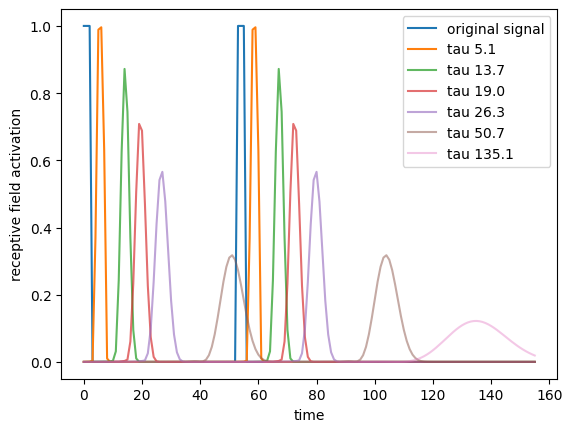

In [21]:
tau_idxs = [5, 8, 9, 10, 12, 15]
taus = sith_cell.tau_stars # the center of each temporal receptive field

plt.plot(signal, label='original signal')

for idx in tau_idxs:
    plt.plot(sith_output[:, idx], label=f'tau {taus[idx]:.1f}', alpha=min(6/idx, 1))

plt.xlabel('time')
plt.ylabel('receptive field activation')
plt.legend();

Each temporal receptive field has an activation that peaks tau units after the signal onset. Notice that the receptive fields further into the past are fuzzier.

SITH geometrically spaces the taus so that the representation is **scale-invariant**. Let's see this more clearly.

In [18]:
sith_cell = CMECell(in_size='scalar',
                    tau_min=1, 
                    tau_max=500,
                    n_taus=1_000, # more taus this time to get a cleaner reconstruction
                    max_fn_evals=10,
                    g=0)

def track_signal_over_time(signal):    
    def step(F, f):
        F, til_f = sith_cell(F, f, alpha=jnp.ones_like(f))
            
        return F, til_f

    final_F, til_fs = jax.lax.scan(step, sith_cell.get_init_F(delta=False), signal)

    return til_fs

sith_output_original = track_signal_over_time(signal)
sith_output_rescaled = track_signal_over_time(jnp.repeat(signal, 2))

Instead plotting time as the x-axis for one receptive field, we'll plot all of the temporal receptive fields on the x-axis at a given time.

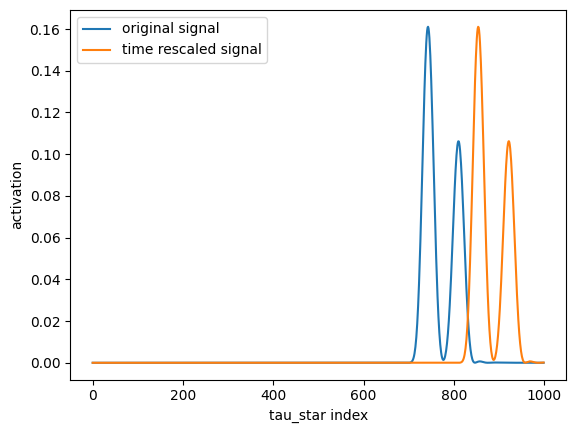

In [26]:
time = -1 # at the end of the signal

plt.plot(sith_output_original[time], label='original signal')
plt.plot(sith_output_rescaled[time], label='time rescaled signal')
plt.xlabel('tau_star index')
plt.ylabel('activation')
plt.legend();

Notice that the time-rescaled SITH response is a translated version of the original response. That's scale invariance!*

*Technically, it's scale equivariance, but with a few minor tweaks (as we'll see in the morse decoder and AudioMNIST examples) it becomes scale invariant.

## Brief Aside

**Q:** Why is the thing we're calling SITH named CME in the code?

**A:** Under the hood, SITH performs an approximate inverse Laplace transform. There are a few numerical 'backends' one can use to make this approximation. In this repo, we use the method of concentrated matrix exponential (CME) distributions proposed by [Horváth et al.](https://www.sciencedirect.com/science/article/pii/S0166531619302457?via%3Dihub)

---

SITH can naturally integrate information over time. Let's work through a quick example.

In [37]:
sith_cell = CMECell(in_size='scalar',
                    tau_min=1, 
                    tau_max=500,
                    n_taus=200,
                    max_fn_evals=10,
                    g=0)

def track_latent_dim(signal):    
    def step(F, f):
        F, til_f = sith_cell(F, jnp.zeros_like(f), alpha=f)
          
        return F, til_f

    final_F, til_fs = jax.lax.scan(step, sith_cell.get_init_F(delta=True), signal)

    return til_fs

We initialize SITH with a brief delta function, and then route the actual signal into the "alpha" argument. 

In [54]:
signal = jnp.concatenate([jnp.ones(20), jnp.zeros(50), jnp.ones(20), jnp.zeros(100)])
sith_output = track_latent_dim(signal)

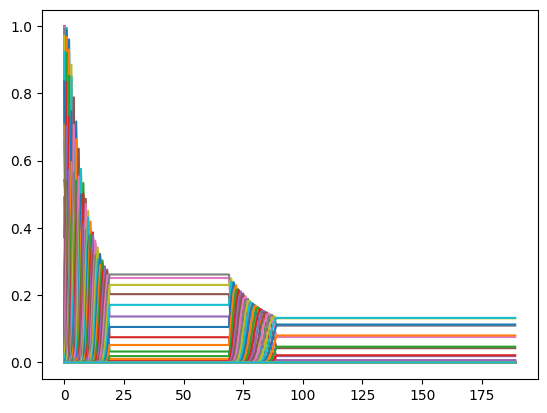

In [57]:
plt.plot(sith_output);